In [11]:
import json
import tensorflow as tf
import json
%matplotlib notebook
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import os
import sys
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from tensorflow.keras.models import Model
tf.keras.backend.set_floatx('float64')
import seaborn as sns

module_path = '/home/zhuo/time_lstm/time_lstm_modules'
if module_path not in sys.path:
    sys.path.append(module_path)

if 'TimeLSTM' in sys.modules:
    importlib.reload(sys.modules['TimeLSTM'])
    
from TimeLSTM import TimeLSTM0

print(sys.path)

['/home/zhuo/notebooks', '/home/zhuo/miniconda3/lib/python37.zip', '/home/zhuo/miniconda3/lib/python3.7', '/home/zhuo/miniconda3/lib/python3.7/lib-dynload', '', '/home/zhuo/miniconda3/lib/python3.7/site-packages', '/home/zhuo/mz-ds-deep-learning/ds-kubeflow', '/home/zhuo/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/zhuo/.ipython', '/home/zhuo/time_lstm/time_lstm_modules']


In [12]:
data_path = './event_sequence_data_20200607_hour_08.json'

with open(data_path, 'r') as f:
    raw_data = json.load(f)

In [13]:
raw_data[0]
raw_data_small = raw_data[:500000]
neg_data = []
pos_data = []

for r in raw_data_small:
    if r['fraud_prob'] > 0:
        pos_data.append(r)
    else:
        neg_data.append(r)

In [15]:
times = []
event_types = []
labels = []

vocab = ['na', 'start', 'view', 'click', 'install']
str2idx = {u:i for i, u in enumerate(vocab)}
idx2str= np.array(vocab)

for row in raw_data_small:
    _event_type_list, _time_list = list(zip(*row['sequence']))
    _event_type_list = tuple(str2idx[c] for c in _event_type_list)
    # drop missing times for data points 5096332 and 8959733
    # otherwise cause problems in creating embeddings
    if not any(_time_list): 
        continue
        
    labels.append(row['fraud_prob'])    
    event_types.append(_event_type_list)

    times.append(_time_list)
    


## Preprocessing

In [33]:
padding_len = 20 
padding_type = 'post'
truncating_type = 'pre'

# padding event types
padded_event_types = tf.keras.preprocessing.sequence.pad_sequences(
    event_types, 
    padding=padding_type, 
    truncating = truncating_type,
    maxlen=padding_len,
    value=0,
    dtype=object,
)
padded_event_types = padded_event_types.astype(int)

#padding time stamps
padded_ts = tf.keras.preprocessing.sequence.pad_sequences(
    times, 
    padding=padding_type, 
    truncating = truncating_type,
    maxlen=padding_len,
    value=0,
    dtype=object,
)
padded_ts = padded_ts.astype(int)
padded_ts = np.diff(padded_ts, axis=1, prepend=0)
padded_ts = padded_ts.astype(np.float64)
padded_ts = padded_ts.clip(0) # remove negative numbers
padded_ts = padded_ts.reshape((DATA_SIZE,20,1))

padded_event_types = padded_event_types.reshape((DATA_SIZE,20,1))


labels = np.array(labels)
train_data_discriminator = padded_event_types,labels


## Simple LSTM for fraud/non-fraud


In [238]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
      loc=[-1., 1],       # One for each component.
      scale=[0.1, 0.5]))  # And same here.

tf.keras.backend.set_floatx('float64')

# x = np.array([1., 2., 3.])
# gm.log_prob(x)
padded_ts = padded_ts.astype(np.float64)
padded_ts = padded_ts.reshape((DATA_SIZE,20,1))
padded_event_types = padded_event_types.reshape((DATA_SIZE,20,1))

features = (padded_event_types, padded_ts)
labels = tf.reshape(labels, (labels.shape[0],1))

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(1000).batch(5, drop_remainder=True)


In [237]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import LSTM
from TimeLSTM import TimeLSTM0,TimeLSTM1
import tensorflow_probability as tfp
tfd = tfp.distributions

DATA_SIZE = 500000
T = 20
batch_size = 3
emb_dim = 2

# Time-LSTM:
i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(20, 1))
masked_ts = mask_layer(i_ts)


embed0 = Embedding(input_dim=len(vocab), output_dim=emb_dim, input_length=20, mask_zero=True,
                   batch_input_shape=[batch_size, None])(i_et) 
embed0 = Reshape((T, emb_dim))(embed0) # shape=[Batch_size, 20, 16]
merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) # # shape=[Batch_size, 20, 17]
 
hm, tm = TimeLSTM1(11, activation='selu',name='time_lstm', return_sequences=False)(merged0)

# tfp.layers.MixtureNormal(num_components, event_shape)

# gaussian mixture for time delta
k_mixt = 7
alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
        probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu, 
            scale=sigma))

gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input

# mask out zeros in time stamps
mask = tf.not_equal(i_ts, 0)

# predicted fraud prob
fraud_prob = Dense(1, activation='sigmoid',name='fraud_prob')(hm)

model_a = Model(
    inputs=[i_et, i_ts], 
    outputs=[fraud_prob, gaussian_log, mask])



## Time-LSTM, Gaussian Mixture Model Training

In [232]:
padded_ts = padded_ts.astype(float)
padded_ts = padded_ts.reshape((DATA_SIZE,20,1))
padded_event_types = padded_event_types.reshape((DATA_SIZE,20,1))

features = (padded_event_types, padded_ts)
labels = tf.reshape(labels, (labels.shape[0],1))

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.batch(100, drop_remainder=True)
loss_history = []
loss_history2 = []

# Adam is doing weird things
optimizer=SGD(lr=0.01)
step = 0
for features, labels_batch in dataset.take(500):
    step+=1
    with tf.GradientTape() as tape:
        fraud, gaussian_log, mask = model_a(features)

        # calculate masked neg-likelihood of gaussian mixture
        gaussian_log = gaussian_log[:, :, 0:1]
        gaussian_log = tf.boolean_mask(gaussian_log, mask)
        gaussian_loss = -tf.reduce_sum(gaussian_log)
        
        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(labels_batch, fraud, from_logits=False))
        loss = gaussian_loss + ce_loss
    
    loss_history.append(gaussian_loss.numpy())
    loss_history2.append(ce_loss.numpy())
    grads = tape.gradient(loss, model_a.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_a.trainable_variables))

    

<IPython.core.display.Javascript object>


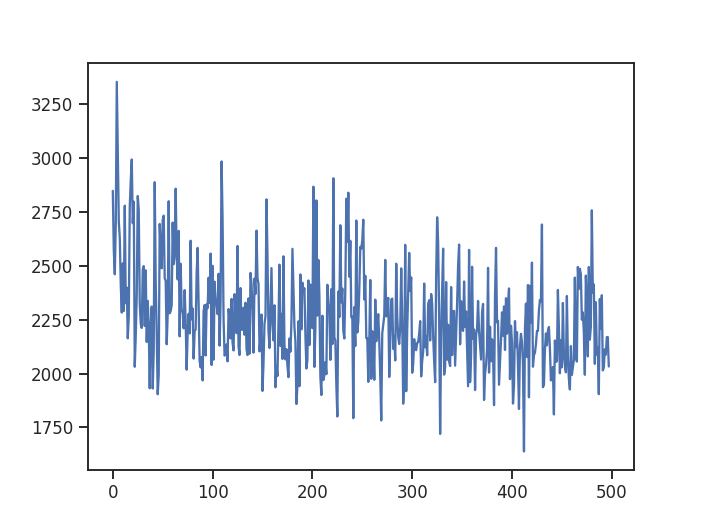

In [236]:
import matplotlib.pyplot as plt
plt.plot(loss_history[2:])



## Discriminator with CNN layers

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

T = 20
batch_size = 1
# time LSTM usage example:
i_et = Input(shape=(T, 1))  # input of discrete feature event type
i_ts = Input(shape=(T, 1))  # input of continuous feature timestamp

outputs = Embedding(input_dim=len(vocab), output_dim=16, input_length=20, batch_input_shape=[batch_size, None])(i_et)
outputs = tf.keras.layers.GRU(32,
                    return_sequences=True,
                    stateful=True,
                    recurrent_initializer='glorot_uniform')(outputs)

# embed0 = Reshape((T, 16))(embed0)
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.GRU(rnn_units,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),

outputs = Dense(1)(outputs)

m = Model(i_et, outputs)
m(padded_event_types[1:100, :])
# merged0 = tf.keras.layers.concatenate([embed0, dense0], axis=2)
# x_b, _ = TimeLSTM0(15, activation='selu')(merged0)
# x_b = Dense(1, activation='sigmoid')(x_b)

# model_b = Model([i_et, i_ts], x_b)
# model_b([padded_event_types[1:5, :], padded_ts[1:5, :]])

# model_b.compile(loss='binary_crossentropy', 
#               optimizer=Adam(lr=0.001),
#              )

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5
# )

# r_b = model_b.fit(
#     [padded_event_types, padded_ts], labels,
#     epochs=1,
# )

# # x_b, _ = TimeLSTM0(15, activation='selu')(merged0)
# # x_b = Dense(1, activation='sigmoid')(x_b)

# # model_b = Model([i_et, i_ts], x_b)

# i_et = Input(shape=(20, 1))  # input of discrete feature event type
# i_ts = Input(shape=(20, 1))  # input of continuous feature timestamp

# # dense0 = Dense(1)(i_ts)

# discriminator = Embedding(len(vocab), 16, \
#                             input_length=padding_len)(i_et)
# discriminator = tf.keras.layers.concatenate([discriminator, dense0], axis=2)
# discriminator = (Conv1D(32, 3, activation='relu'))(discriminator)
# discriminator.add(MaxPooling1D(5))
# discriminator.add(Conv1D(32, 3, activation='relu'))
# discriminator.add(GlobalMaxPooling1D())
# discriminator.add(Dense(1))
# discriminator.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy',metrics=['acc'])
# history = discriminator.fit(inp, labels,
# epochs=2, batch_size=500, validation_split=0.2)


# dataset = tf.data.Dataset.from_tensor_slices(train_data_discriminator)
# dataset = dataset.shuffle(BUFFER_SIZE).batch(500, drop_remainder=True)
# discriminator.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy',metrics=['acc'])
# discriminator.fit(dataset)

ValueError: Input 0 of layer gru is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 20, 1, 16]

## Pre-train Generator model

In [42]:

features = (padded_event_types, padded_ts)
labels = tf.reshape(labels, (labels.shape[0],1))

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(1000).batch(3, drop_remainder=True)
loss_history = []
optimizer=Adam(lr=0.001)

def split_input_target(chunk):
    input_text = chunk[:, :-1, :]
    target_text = chunk[:, 1:, :]
    return input_text, target_text

for features, labels_batch in dataset.take(1):
    et, ts = features
    input_ts, target_ts = split_input_target(ts)
    input_et, target_et = split_input_target(et)
    
    

In [43]:

# dataset = tf.data.Dataset.from_tensor_slices(pos_padded_event_types)
# dataset = dataset.map(split_input_target)

# BATCH_SIZE = 12
# BUFFER_SIZE = 1000

# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# for input_example, target_example in  dataset.take(1):
#     print('input_example:{}'.format(input_example))
#     print('target_example:{}'.format(target_example))
# input_example.shape


In [84]:

dataset = tf.data.Dataset.from_tensor_slices(train_et)
dataset = dataset.map(split_input_target)

BATCH_SIZE = 1
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

for input_example, target_example in  dataset.take(1):
    print('input_example:{}'.format(input_example))
    print('target_example:{}'.format(target_example))
    
et = train_et[0,:]
ts = train_ts[0,:]
    
i_et = Input(shape=(T,1))  # input of discrete feature event type
i_ts = Input(shape=(T,1))  # input of continuous feature timestamp

embed0 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,)(i_et)
embed0 = Reshape((T, 16))(embed0)
merged0 = tf.keras.layers.concatenate([embed0, i_ts], axis=2)

x_b, _ = TimeLSTM0(15, activation='selu')(merged0)
x_b = Dense(vocab_size, activation='sigmoid')(x_b)
model_b = Model([i_et, i_ts], x_b)



input_example:[[[1]
  [2]
  [1]
  [2]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]]
target_example:[[[2]
  [1]
  [2]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]]


TensorShape([1, 19, 1])

## Train Generator based on Time-LSTM

In [86]:
vocab_size = len(vocab)
embedding_dim = 16
rnn_units = 32
T = 19
def build_model_time_lstm(vocab_size, embedding_dim, rnn_units, batch_size=1):
    
    i_et = Input(shape=(T,1))  # input of discrete feature event type
    i_ts = Input(shape=(T,1))  # input of continuous feature timestamp

    embed0 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,)(i_et)
    embed0 = Reshape((T, 16))(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, i_ts], axis=2)
    
    x_b, _ = TimeLSTM0(15, activation='selu')(merged0)
    x_b = Dense(vocab_size, activation='sigmoid')(x_b)
    model_b = Model([i_et, i_ts], x_b)
    model_b.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=0.001),
                 )
    return model_b

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model = build_model_time_lstm(vocab_size = len(vocab),
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=1)
for input_example, target_example in  dataset.take(1):
    print(input_example.shape)
    print(model(input_example).shape)


(1, 19, 1)


AssertionError: Could not compute output Tensor("dense_63/Identity:0", shape=(None, 5), dtype=float64)

In [28]:
vocab_size = len(vocab)
embedding_dim = 16
rnn_units = 32

def build_model(vocab_size, embedding_dim, rnn_units, batch_size=1):
    
    i_et = Input(shape=(T,1))  # input of discrete feature event type
    i_ts = Input(shape=(T,1))  # input of continuous feature timestamp

    embed0 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,),
    embed0 = Reshape((T, 16))(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, i_ts], axis=2)

        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model = build_model(vocab_size = len(vocab),
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=BATCH_SIZE)
for input_example, target_example in  dataset.take(1):
    print(input_example.shape)
    print(model(input_example).shape)

# model.compile(optimizer='adam', loss=loss)

# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True)

# EPOCHS = 2
# history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


(10, 19)
(10, 19, 5)


NameError: name 'dataset' is not defined

In [62]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model


## Generator model

In [254]:
checkpoint_dir = './training_checkpoints'

tf.train.latest_checkpoint(checkpoint_dir)
generator = build_model(vocab_size, embedding_dim, rnn_units, batch_size=50)

generator.load_weights(tf.train.latest_checkpoint(checkpoint_dir))


## Roll-out policy

In [257]:
def generate_event(model, batch_size=50, length=20):
    states = [1] * batch_size
    states = tf.expand_dims(states, -1)
    all_actions_one_hot = tf.one_hot(states, depth=5)
    all_predicted_actions = None
    
    model.reset_states()
    for i in range(length):
        predictions = model(states)
        if all_predicted_actions is None:
            all_predicted_actions = predictions
        else:
            all_predicted_actions =tf.keras.layers.concatenate([all_predicted_actions, predictions], axis=1)
        
        # sample an action - token
        predictions = tf.squeeze(predictions)
        predicted_idx = tf.random.categorical(predictions, num_samples=1)
        
        # maintain 16 gaussians, use predicted_idx to index which one to use to sample
        current_gaussian = list_gaussian[predicted_idx, prev_predicted_idx]
        current_delta_t = current_gaussian(sample
                                          )
        
        # sample a timestamp - Gaussian?
        predicted_idx_one_hot = tf.one_hot(predicted_idx, depth=5)
        all_actions_one_hot = tf.concat([all_actions_one_hot, predicted_idx_one_hot], axis=1)
        
        # pass the predicted action as the next input to the model
        states = predicted_idx

    return  all_actions_one_hot, all_predicted_actions


In [297]:

optimizer = tf.keras.optimizers.Adam()
loss_history = []
g_steps = 10
d_steps = 10
# Generator training

for i in range(g_steps):
    with tf.GradientTape() as tape:
        all_actions_one_hot, all_predicted_actions = generate_event(generator, length=20)
        all_actions_one_hot = all_actions_one_hot[:, 1:,]

        # policy gradient loss
        negative_likelihoods = tf.keras.losses.categorical_crossentropy\
            (all_actions_one_hot, all_predicted_actions,from_logits=True)
        in_dis = tf.argmax(all_actions_one_hot, axis = -1)
        q_values = tf.broadcast_to(discriminator(in_dis), negative_likelihoods.shape) # this needs N-time Monte Carlo search
        weighted_negative_likelihoods = tf.multiply(negative_likelihoods, q_values)
        loss = tf.reduce_mean(weighted_negative_likelihoods)

    loss_history.append(loss.numpy())
    print('loss:{}'.format(loss.numpy()))
    grads = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
# Discriminator training
for i in range(d_steps):
    with tf.GradientTape() as tape:
        all_actions_one_hot, all_predicted_actions = generate_event(generator, length=20)
        all_actions_one_hot = all_actions_one_hot[:, 1:,]

        fake_train = tf.argmax(all_actions_one_hot, axis = -1)
        fake_labels = tf.zeros(in_dis.shape[0])

        real_train = np.random.permutation(pos_padded_event_types)[:50]
        real_labels = tf.ones(real_train.shape[0])
        train_all = np.concatenate((real_train, fake_train), axis=0)
        labels_all = np.concatenate((real_labels, fake_labels, ), axis=0)

        pred = discriminator(train_all)
        dis_loss = tf.keras.losses.categorical_crossentropy\
                (labels_all, pred, from_logits=True)

    print('loss:{}'.format(dis_loss.numpy()))
    grads = tape.gradient(dis_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))



loss:-0.028991742059588432
loss:-0.029290182515978813
loss:-0.029063435271382332
loss:-0.03051750175654888
loss:-0.03157886117696762
loss:-0.03368803858757019
loss:-0.030589960515499115
loss:-0.03016679361462593
loss:-0.03109685517847538
loss:-0.031214972957968712
loss:[230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853

InvalidArgumentError: Input to reshape is a tensor with 10000 values, but the requested shape has 100 [Op:Reshape]

loss:[230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853 230.25853
 

InvalidArgumentError: Input to reshape is a tensor with 10000 values, but the requested shape has 100 [Op:Reshape]

In [267]:
all_actions_one_hot, all_predicted_actions = generate_event(generator, length=20)
all_actions_one_hot = all_actions_one_hot[:, 1:,]
all_actions_one_hot
# policy gradient loss
negative_likelihoods = tf.keras.losses.categorical_crossentropy\
    (all_actions_one_hot, all_predicted_actions,from_logits=True)
in_dis = tf.argmax(all_actions_one_hot, axis = -1)
print(in_dis.shape)
discriminator(in_dis)
q_values = tf.broadcast_to(discriminator(in_dis), negative_likelihoods.shape) # this needs N-time Monte Carlo search
weighted_negative_likelihoods = tf.multiply(negative_likelihoods, q_values)
loss = tf.reduce_mean(weighted_negative_likelihoods)
    
print(negative_likelihoods.shape)
print(in_dis.shape)
print(q_values.shape)
q_values

(50, 20)
(50, 20)
(50, 20)
(50, 20)


<tf.Tensor: shape=(50, 20), dtype=float32, numpy=
array([[-0.03283375, -0.03283375, -0.03283375, -0.03283375, -0.03283375,
        -0.03283375, -0.03283375, -0.03283375, -0.03283375, -0.03283375,
        -0.03283375, -0.03283375, -0.03283375, -0.03283375, -0.03283375,
        -0.03283375, -0.03283375, -0.03283375, -0.03283375, -0.03283375],
       [-0.02649174, -0.02649174, -0.02649174, -0.02649174, -0.02649174,
        -0.02649174, -0.02649174, -0.02649174, -0.02649174, -0.02649174,
        -0.02649174, -0.02649174, -0.02649174, -0.02649174, -0.02649174,
        -0.02649174, -0.02649174, -0.02649174, -0.02649174, -0.02649174],
       [-0.03558667, -0.03558667, -0.03558667, -0.03558667, -0.03558667,
        -0.03558667, -0.03558667, -0.03558667, -0.03558667, -0.03558667,
        -0.03558667, -0.03558667, -0.03558667, -0.03558667, -0.03558667,
        -0.03558667, -0.03558667, -0.03558667, -0.03558667, -0.03558667],
       [-0.03349002, -0.03349002, -0.03349002, -0.03349002, -0.03349002

In [ ]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
    
        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))

        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    print('grads:{}'.format(grads))
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    return grads


In [112]:
# for i in range(20):
seq_str, seq_int = generate_event(model)
#     print(seq_str)


start view view view view click view view start view install install view click view start install start install click view 
start start click view install start view click view view view install click start view view install install view view na 
start click install install click install na click na na na na na na na na na na na na na 
start click click view view view view install start na install click view view start start start install start click view 
start view start view start click click click install click view install start view install start click start start view install 
start start start click view view view na na na na na na na na na na na na na na 
start view view start start view view view install click start start start click view install click view click click view 
start view view click install start view view click start install click view install start click click view start view install 
start view install view click view install start view click install click v

In [113]:
seq_int

[2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 2, 3, 4, 4]

In [127]:
# Discriminator - CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(len(vocab), 16, input_length=20))
cnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1))
cnn_model.summary()
cnn_model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy',metrics=['acc'])
# history = model.fit(x_train, y_train,
# epochs=10, batch_size=128, validation_split=0.2)
cnn_model.predict(np.array([seq_int]))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 20, 16)            80        
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 18, 32)            1568      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4, 32)             3104      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 4,785
Trainable params: 4,785
Non-trainable params: 0
___________________________________________________

array([[0.02621368]], dtype=float32)

In [97]:
class Environment(object):
    def __init__(self, discriminator, rollout_policy, path):
        self.path = path
        self.discriminator = discriminator
        self.mdp = rollout_policy # an pretrained RNN model
        self.base_state = [1]
        self.state = self.base_state
        self.reset()
        self.T = 20
        self.n_sample = 100
    
    def load_model():
        tf.train.latest_checkpoint(checkpoint_dir)
        model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
        model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
        model.build(tf.TensorShape([1, None]))
        model.summary()
        
    def get_state(self):
        return self.state
    
    def reset(self):
        self.t = t
        self.mdp.reset_states()
        self.state = self.base_state
        return True
    
    def step(self, action):
        self.t = self.t + 1

        reward = self.get_reward(action, self.n_sample)
        is_episode_end = self.t > self.T

        self.state.append(action)
        next_state = self.get_state()

        return [next_state, reward, is_episode_end]
    
    def render(self):
        for c in self.state:
            
        full_seq_str.append(idx2str[predicted_idx] + " ")
        full_seq_int.append(predicted_idx)

    return 'start ' + ''.join(full_seq_str), full_seq_int


    def get_reward(self, action, n_sample):
        reward = 0
        for idx_sample in range(n_sample):
            full_seq = self.generate_event(state, self.T)
            reward += self.discriminator.predict(full_seq) / n_sample
        return reward
        
    def generate_event(state, length):
        input_eval = state
        input_eval = tf.expand_dims(input_eval, 0)
        full_seq = input_eval
        # Empty string to store our results
        text_generated = []

        self.rollout_policy.reset_states()
        for i in range(length):
            predictions = mdp(input_eval)
            predictions = tf.squeeze(predictions, 0)
            predictions = predictions
            predicted_idx = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
            
            # pass the predicted action as the next input to the model
            input_eval = tf.expand_dims([predicted_idx], 0)
            text_generated.append(idx2str[predicted_idx])
            full_seq.append(predicted_idx)
        return full_seq

    